# Project: Indeed Data Science Jobs Market Analysis (2024)

## Introduction
This project involves data scraping and exploratory data analysis (EDA) of job listings from the Indeed.com website. It focuses on the job market for data scientists from 130 companies in the USA as of October 2024.

## Tools & Modules Used
Python3 | Jupyer | Selenium | Pandas | Plotly | Numpy | Matplotlib | Seaborn

## Import Library

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service
import csv
from typing import List, Dict
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from IPython.display import display
import json



## Scraping the data

Data Collection: This project relies on web scraping using Selenium.

In [4]:
driver = webdriver.Chrome() 


job_listings = []

for page in range(0, 100, 10):
    url = f"https://www.indeed.com/jobs?q=data+scientist&l=usa&start={page}"
    
    # Set up Chrome options with User-Agent header
    chrome_options = Options()
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    # Initialize the WebDriver
    driver.get(url)
    time.sleep(3)  # Wait for the page to load

    job_elements = driver.find_elements(By.CLASS_NAME, "job_seen_beacon")

    try:
        w = WebDriverWait(driver, 10)
        w.until(EC.presence_of_element_located((By.CLASS_NAME,"job_seen_beacon")))
    except:
        driver.quit()
    
    i = 0
    for job in job_elements:
        i = i + 1
        
        try:
            title_element = driver.find_element(By.XPATH, f"/html/body/main/div/div[2]/div/div[5]/div/div[1]/div[5]/div/ul/li[{i}]/div/div/div/div/div/div/table/tbody/tr/td[1]/div[1]/h2/a")
            company_element = driver.find_element(By.XPATH, f"/html/body/main/div/div[2]/div/div[5]/div/div[1]/div[5]/div/ul/li[{i}]/div/div/div/div/div/div/table/tbody/tr/td[1]/div[2]/div/div[1]/span")
            city_element = driver.find_element(By.XPATH, f"/html/body/main/div/div[2]/div/div[5]/div/div[1]/div[5]/div/ul/li[{i}]/div/div/div/div/div/div/table/tbody/tr/td[1]/div[2]/div/div[2]")
            
            title_element.click()
            time.sleep(6)
            
            description_full = driver.find_element(By.ID, "jobDescriptionText")
            
            try:
                company_rating = driver.find_element(By.XPATH, f"/html/body/main/div/div[2]/div/div[5]/div/div[2]/div/div/div[2]/div[2]/div[1]/div/div[1]/div[2]/div/div/div/div[1]/div[2]/span[1]").text
            except NoSuchElementException:
                company_rating = 0  # Set 0 if the company rating is not found
            
            job_listings.append({
                'title': title_element.text,
                'company': company_element.text,
                'location': city_element.text,
                'rating' : company_rating,
                'description' : description_full.text
            })
                
        except:
            pass

driver.quit()  # Close the WebDriver

## Creating the data frame and saving the scrapped data

In [5]:
job_listings

[{'title': 'Data Scientist',
  'company': 'SAS',
  'location': 'Remote in Cary, NC 27513',
  'rating': '4.1',
  'description': ''},
 {'title': '2025 Cat Digital Early Career Data Scientist Opportunities',
  'company': 'Caterpillar',
  'location': 'Peoria, IL',
  'rating': 0,
  'description': "Career Area:\nBusiness Technologies, Digital and Data\nJob Description:\nYour Work Shapes the World at Caterpillar Inc.\nWhen you join Caterpillar, you're joining a global team who cares not just about the work we do – but also about each other. We are the makers, problem solvers, and future world builders who are creating stronger, more sustainable communities. We don't just talk about progress and innovation here – we make it happen, with our customers, where we work and live. Together, we are building a better world, so we can all enjoy living in it.\nYour Work Shapes the World at Caterpillar Inc.\nWhen you join Caterpillar, you're joining a global team who cares not just about the work we do –

In [6]:
# Save all job data to a JSON file
with open("data_jobs.json", "w", encoding="utf-8") as f:
    json.dump(job_listings, f, ensure_ascii=False, indent=4)

In [7]:
# Read the json file into a DataFrame
df = pd.read_json('data_jobs.json', encoding='utf-8')

# Display the first few rows of the DataFrame
print(df.head())
print(df.info())
print(df.columns)


                                               title                company  \
0                                     Data Scientist                    SAS   
1  2025 Cat Digital Early Career Data Scientist O...            Caterpillar   
2                         Data Scientist II (Remote)                  KOHLS   
3                              Junior Data Scientist                   Lidl   
4                                   Data Scientist I  University of Florida   

                              location rating  \
0             Remote in Cary, NC 27513    4.1   
1                           Peoria, IL      0   
2  Remote in Menomonee Falls, WI 53051    3.6   
3        Remote in Arlington, VA 22202      0   
4                Gainesville, FL 32611    4.2   

                                         description  
0                                                     
1  Career Area:\nBusiness Technologies, Digital a...  
2  About the Role\nIn this role you will work wit...  
3  Locatio

In [8]:
print(df.describe())

                 title               company location  rating description
count              130                   130      130     130         130
unique              62                    98       95      20         101
top     Data Scientist  Valley National Bank   Remote       0            
freq                54                     4        6      38          10


Next steps is to:
1. Handle Missing Ratings: Since ratings are missing for some entries, we will fill them with a default value 0.

2. Split location into city and zip

In [9]:
#lets lower case all the strings to avoid redundancy
df = df.apply(lambda x: x.astype(str).str.lower())

# Split the location column by comma and expand into separate columns
df[['city', 'state_zip']] = df['location'].str.split(',', expand=True)

# Change the rating column type to float, converting non-numeric values to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Fill NaN values with 0
df['rating'].fillna(0, inplace=True)

print(df.head())
print(df.info())


                                               title                company  \
0                                     data scientist                    sas   
1  2025 cat digital early career data scientist o...            caterpillar   
2                         data scientist ii (remote)                  kohls   
3                              junior data scientist                   lidl   
4                                   data scientist i  university of florida   

                              location  rating  \
0             remote in cary, nc 27513     4.1   
1                           peoria, il     0.0   
2  remote in menomonee falls, wi 53051     3.6   
3        remote in arlington, va 22202     0.0   
4                gainesville, fl 32611     4.2   

                                         description  \
0                                                      
1  career area:\nbusiness technologies, digital a...   
2  about the role\nin this role you will work wit...   


C:\Users\braja\AppData\Local\Temp\ipykernel_12252\2533074553.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(0, inplace=True)


## Exploratory Data Analysis

The purpose of the EDA:
1. Analyze Job Locations
2. Company and Role Distribution
3. Description Content to analyze common skills and requirements

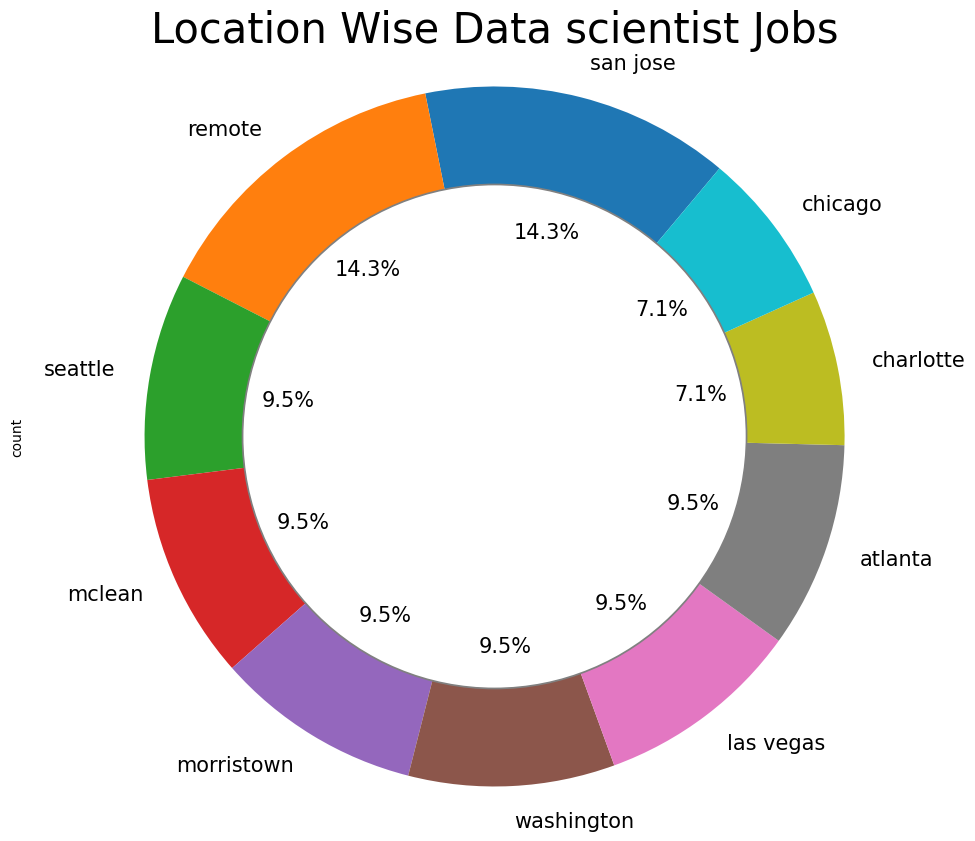

In [10]:
df.city.apply(pd.Series).stack().str.strip().value_counts()[:10].plot.pie(figsize=(12,10),startangle=50,autopct='%1.1f%%',fontsize=15)
plt.title("Location Wise Data scientist Jobs",fontsize=30)

centre_circle = plt.Circle((0,0),0.72,color='gray', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

From the job postings, we can see the Data Science field still have remote jobs opening 14.3%

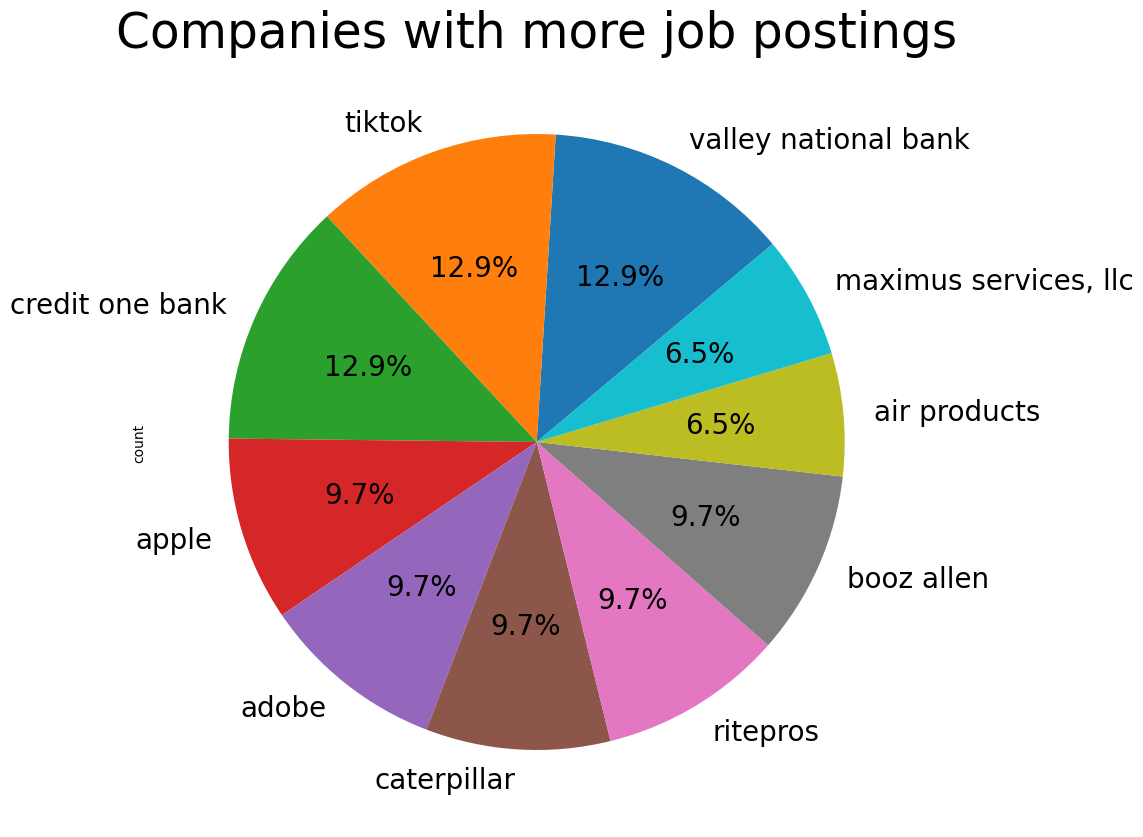

In [11]:
df['company'].value_counts()[:10].plot.pie(figsize=(12,10), startangle=40, autopct='%1.1f%%', fontsize=20)
plt.title("Companies with more job postings",fontsize=35)
plt.show()

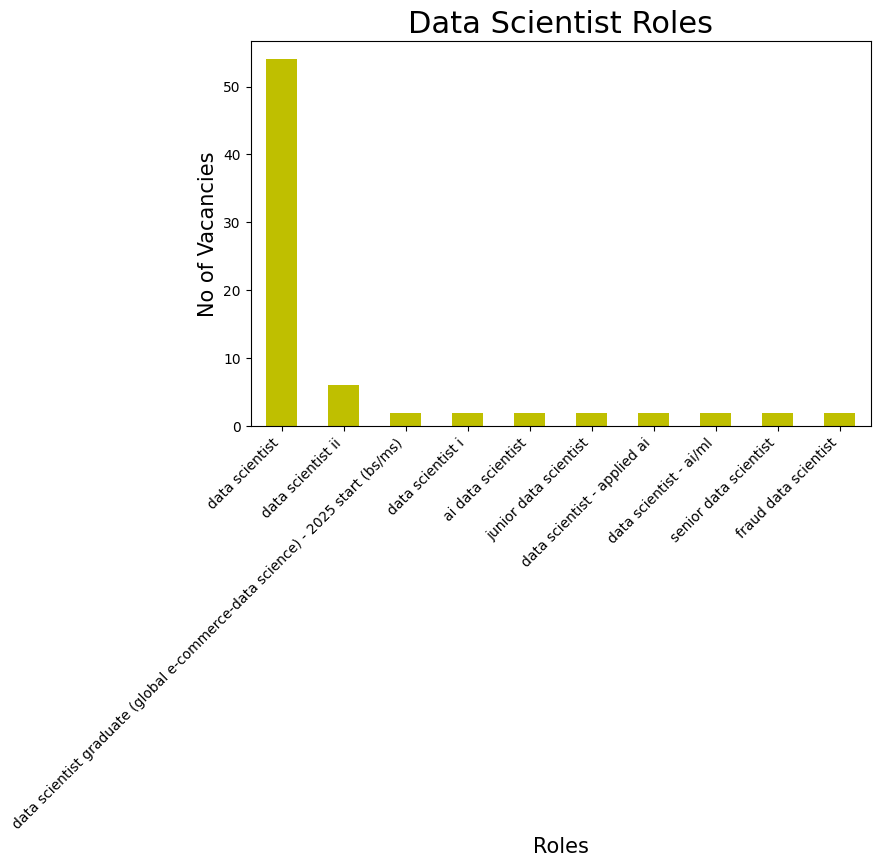

In [12]:
# Roles
df["title"].value_counts()[:10].plot.bar(figsize=(8,5),fontsize=10,color="y")
plt.xticks(rotation=45,ha='right')
plt.title("Data Scientist Roles",fontsize=22)
plt.ylabel("No of Vacancies",fontsize=15,rotation=90)
plt.xlabel("Roles",fontsize=15)
plt.show()

We can see Tiktok, Credit One Bank, and Valley National Bank is listing the most jobs, and Data Scientist role is the highest demand.

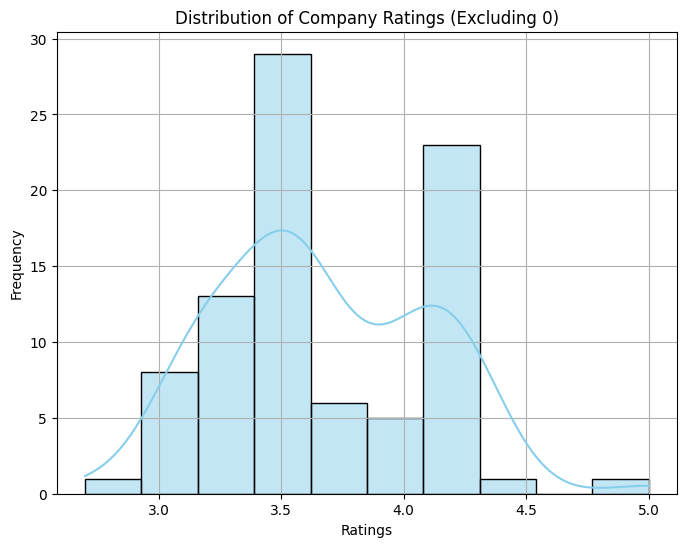

In [13]:
# Filter out ratings with value 0
filtered_ratings = df[df['rating'] > 0]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_ratings['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Company Ratings (Excluding 0)')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

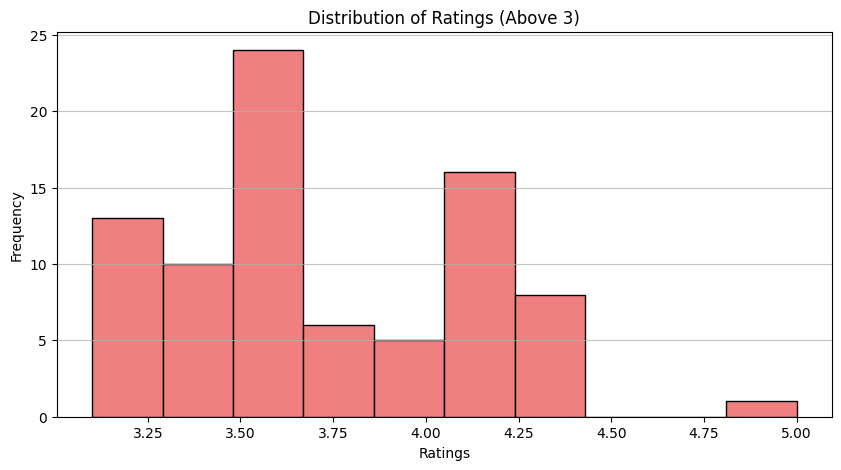

In [14]:
# Filter companies with ratings above 3
high_rated_companies = df[df['rating'] > 3]

# Plotting a histogram for ratings above 3
plt.figure(figsize=(10, 5))
plt.hist(high_rated_companies['rating'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Distribution of Ratings (Above 3)')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

From the plot, we can see most of the companies have rating above 3.5

In [16]:
# Select relevant columns (e.g., company name and rating)
highest_rated = df[df['rating'] > 3.5]
high_rated_companies_list = highest_rated[['company', 'rating']]

# Display the list as an interactive table
display(high_rated_companies_list)

,company,rating
0,sas,4.1
2,kohls,3.6
4,university of florida,4.2
12,adobe,4.3
14,johnson & johnson,4.2
15,world bank group,4.3
20,apple,4.1
23,lexisnexis,3.6
30,vanguard,3.6
31,georgia tech,4.1


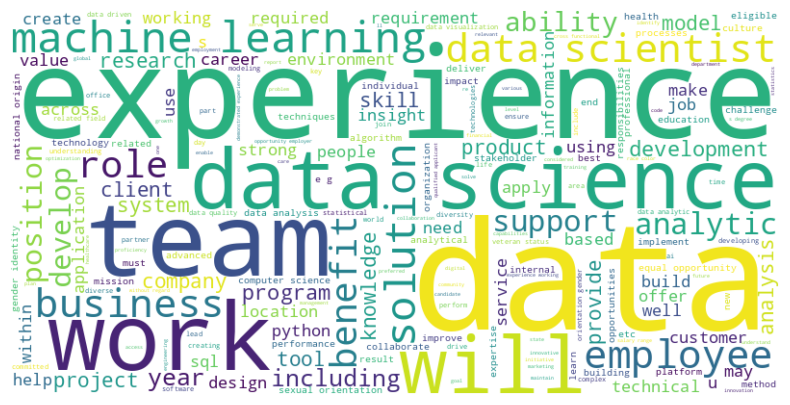

In [17]:
# Combine all descriptions into a single string
text = ' '.join(df['description'].dropna())  # Drop NaN values to avoid errors

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


From the word clouds, we can see that experience is the most important factor for data scientists. Additionally, the words 'data' and 'team' are also highlighted.

In [18]:
# List of terms to count
terms = ['machine learning', 'data science', 'python', 'data analysis', 'artificial intelligence', 'sql', 'nlp', 'deep learning']

# Initialize a dictionary to hold the counts
term_counts = {term: 0 for term in terms}

# Count occurrences of each term in the description column
for term in terms:
    term_counts[term] = df['description'].str.lower().str.count(term).sum()  # Convert to lower case for case-insensitive counting

# Display the counts
print(term_counts)

{'machine learning': np.int64(221), 'data science': np.int64(256), 'python': np.int64(137), 'data analysis': np.int64(74), 'artificial intelligence': np.int64(19), 'sql': np.int64(118), 'nlp': np.int64(28), 'deep learning': np.int64(21)}


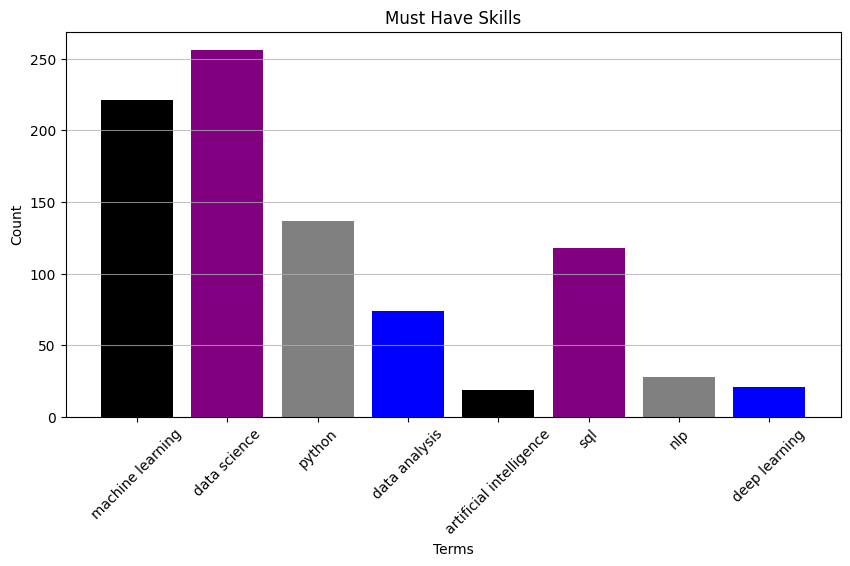

In [19]:
# Create a bar plot for the word counts
plt.figure(figsize=(10, 5))
plt.bar(term_counts.keys(), term_counts.values(), color=["black","purple","grey","blue"])
plt.title('Must Have Skills')
plt.xlabel('Terms')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

{'python': np.int64(137), 'sql': np.int64(118), 'sas': np.int64(26), 'java': np.int64(26)}


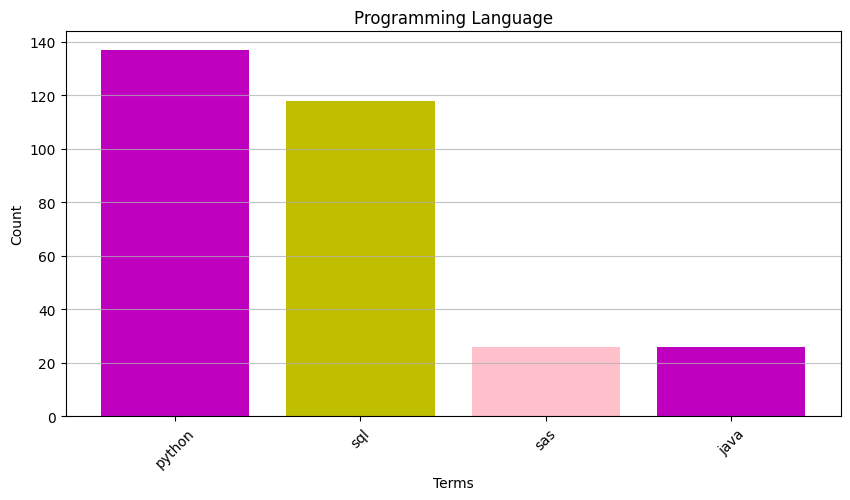

In [20]:
# List of terms to count
terms = ['python', 'sql', 'sas', 'java']

# Initialize a dictionary to hold the counts
term_counts = {term: 0 for term in terms}

# Count occurrences of each term in the description column
for term in terms:
    term_counts[term] = df['description'].str.lower().str.count(term).sum()  # Convert to lower case for case-insensitive counting

# Display the counts
print(term_counts)

# Create a bar plot for the word counts
plt.figure(figsize=(10, 5))
plt.bar(term_counts.keys(), term_counts.values(), color=["m","y","pink"])
plt.title('Programming Language')
plt.xlabel('Terms')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

{'spark': np.int64(52), 'hadoop': np.int64(19), 'hive': np.int64(16)}


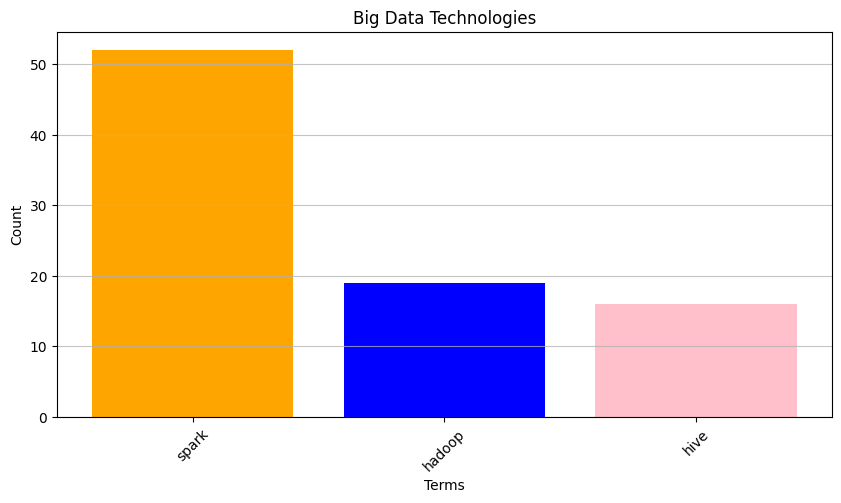

In [21]:
# List of terms to count
terms = ['spark', 'hadoop', 'hive']

# Initialize a dictionary to hold the counts
term_counts = {term: 0 for term in terms}

# Count occurrences of each term in the description column
for term in terms:
    term_counts[term] = df['description'].str.lower().str.count(term).sum()  # Convert to lower case for case-insensitive counting

# Display the counts
print(term_counts)

# Create a bar plot for the word counts
plt.figure(figsize=(10, 5))
plt.bar(term_counts.keys(), term_counts.values(), color=["orange","blue","pink"])
plt.title('Big Data Technologies')
plt.xlabel('Terms')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

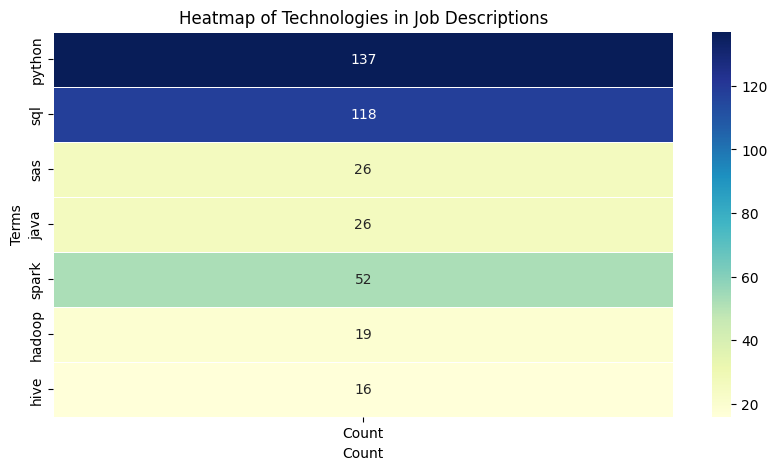

In [22]:
# List of terms to count
terms = ['python', 'sql', 'sas', 'java', 'spark', 'hadoop', 'hive']

# Initialize a dictionary to hold the counts
term_counts = {term: 0 for term in terms}

# Count occurrences of each term in the description column
for term in terms:
    term_counts[term] = df['description'].str.lower().str.count(term).sum()  # Convert to lower case for case-insensitive counting

# Create a DataFrame for the heatmap
heatmap_data = pd.DataFrame(list(term_counts.items()), columns=['Term', 'Count'])

# Reshape the DataFrame for heatmap
heatmap_matrix = heatmap_data.set_index('Term')

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_matrix, annot=True, cmap='YlGnBu', cbar=True, fmt='g', linewidths=.5)
plt.title('Heatmap of Technologies in Job Descriptions')
plt.xlabel('Count')
plt.ylabel('Terms')
plt.show()

## Conclusion

The job market for Data Science remains strong in the USA, with 14.3% of positions offering remote work. The top three programming languages in demand are Python, SQL, and SAS. Among big data technologies, Spark is the most commonly used. Machine learning continues to be an essential skill for data scientists.